In [1]:
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.eval_measures import rmspe, aic, bic

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

The present notebook contains the code for the second challenge. We are tasked with building a model that prices the diamonds while providing a simple explaination for the predicted price. <br>

The log-linear models  explored in the previous section are a good starting point. Since we are interested in developing a model that can generalize to unseen data, we need to divide the data at hand into a training, validation and test sets.

In [3]:
data = pd.read_csv('./datasets/diamonds/diamonds.csv')

# remove nan values
data = data[~data.isna().any(axis = 1)]
        
# remove non-positive prices, table and depth
data = data[data['price'] >0]
data = data[data['table'] >0]
data = data[data['depth'] >0]


# remove non-positive lenghts  
data = data[data['x'] >0]
data = data[data['y'] >0]
data = data[data['z'] >0]

# introduce the required variables
data['log_carat'] = np.log(data['carat'])
data['log_price'] = np.log(data['price'])
data['log_table'] = np.log(data['table'])
data['log_depth'] = np.log(data['depth'])

# Introduce numerical variables for color, cut and clarity
data[['clarity_num', 'color_num', 'cut_num']] = data.apply(
        lambda x: pd.Series({
            'clarity_num':  clarity_numerical_values[x['clarity']],
            'color_num':    colors_numerical_values[x['color']],
            'cut_num':      cut_numerical_values[x['cut']] 
        }), axis = 1
    )

data['color_clarity'] = data.apply(lambda x: x['color'] + '_' + x['clarity'], axis = 1)

# define the train, validation and test percentages
validation_perc = 0.2
test_perc = 0.2
train_prec = 1 - (test_perc + validation_perc)

# shuffle and divide into train test and validation percentages
idx = np.random.permutation(len(data))
train_df        = data.iloc[idx[:int(len(data)*train_prec)]]
validation_df   = data.iloc[idx[ int(len(data)*train_prec): int(len(data)*train_prec)+int(len(data)*validation_perc)]]
test_df         = data.iloc[int(len(data)*train_prec)+int(len(data)*validation_perc):]

# check len consistency
print('Data records', len(data))
print('Train records: ', len(train_df))
print('Validation records: ', len(validation_df))
print('Test records: ', len(test_df))
print('Split check :', len(test_df) + len(validation_df) + len(train_df))

Data records 4989
Train records:  2993
Validation records:  997
Test records:  999
Split check : 4989


In [4]:
# Define the metrics to compare the models
def r_squared(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mean_y = np.mean(y_true)
    ss_tot = np.sum((y_true - mean_y)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - ss_res / ss_tot
    return r2

def adjusted_r_squared(y_true, y_pred, n_features):
    r2 = r_squared(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adj_r2

def meanabs(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = y_pred - y_true
    error = np.abs(error)
    error = np.nanmean(error)
    return error

def compute_metrics(models, df, results, dependent_variable):
    results['r2']        = [r_squared            (m.predict(df), df[dependent_variable]) for m in models]
    results['r2_adj']    = [adjusted_r_squared   (m.predict(df), df[dependent_variable], n_features=len(m.params)) for m in models]
    results['meanabs']   = [meanabs              (m.predict(df), df[dependent_variable]) for m in models]
    results['rmspe']     = [rmspe                (m.predict(df), df[dependent_variable]) for m in models]
    # results['rmedspe']   = [rmedspe              (m.predict(df), df[dependent_variable]) for m in models]

    return results


In [5]:
# Define the functions to fit and compare the models
def fit_and_analyze(models_f, train_df, validation_df, dependent_variable):

    # Initialize and fit the models
    models = [
        ols(formula=formula, data=train_df).fit() for formula in models_f
    ]

    # Initialize the metrics datasets containing the results of the fit
    idx_start_name = 8 if dependent_variable == 'price' else 12
    results = dict(zip([formula[idx_start_name:] for formula in models_f], [i for i in range(len(models_f))]))
    results = pd.DataFrame.from_dict(results, orient='index')

    # Compute the metrics on the train datasets
    results = compute_metrics(models, train_df, results, dependent_variable)
    results.drop(0, axis = 1, inplace = True)
    metrics_names = [col for col in results.columns]
    results.columns = [col + '_train' for col in results.columns]

    # Compute the metrics on the validation datasets
    results = compute_metrics(models, test_df, results, dependent_variable)
    results.columns = [col if 'train' in col else col + '_validate' for col in results.columns]
    results = results[sorted(results.columns)]

    # Add the degrees of freedom for each model and sort the results dataset by them
    results['df'] = [m.df_model for m in models]
    results = results.sort_values('df')
    return models, results

def compare_models(results, n = 5):
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize = (30, 6))
    metrics = ['r2_adj', 'rmspe', 'meanabs']

    for i, metric in enumerate(metrics):
        res_to_plot = {
            'train': results[metric + '_train'],
            'validate':  results[metric + '_validate']
        }
        
        sns.scatterplot(x = range(len(results)), y = res_to_plot['train'], ax = axes[i])
        sns.scatterplot(x = range(len(results)), y = res_to_plot['validate'],  ax = axes[i], c = 'red')
        if metric == 'r2_adj':
            axes[i].axhline(res_to_plot['validate'].max(), c = 'orange')
        else:
            axes[i].axhline(res_to_plot['validate'].min(), c = 'orange')

        # Add the reference to the models implemented
        _ = axes[i].set_xticks(np.arange(len(results)), list(results.index), rotation = -90)
        _ = [axes[i].axvline(r, c = 'k', linestyle = '--', alpha = 0.2) for r in np.arange(len(results))]


        # Suppress the name on the vertical y-axis
        _ = axes[i].set_ylabel(None)
        _ = axes[i].set_title(metric)

        # Print the best models according the metric
        ascending = False if metric == 'r2_adj' else True
        print(f'Top {n} models and their degrees of freedom according to the {metric} metric')
        print(results[[metric + '_validate', 'df']].sort_values(metric + '_validate', ascending = ascending)[:n].to_string())


Top 5 models and their degrees of freedom according to the r2_adj metric
                                         r2_adj_validate     df
carat * color * clarity                         0.930883  111.0
carat + color + clarity + table                 0.915758   15.0
carat + color + clarity + depth + table         0.915743   16.0
carat + color + clarity + depth * table         0.915627   17.0
carat + color + clarity * depth * table         0.914598   38.0
Top 5 models and their degrees of freedom according to the rmspe metric
                                         rmspe_validate    df
carat + color + clarity * depth               38.709193  22.0
carat + color + clarity + depth * table       39.183257  17.0
carat + color + clarity + depth + table       46.388675  16.0
carat + color * clarity                       53.791597  56.0
carat + color + clarity + table               63.974777  15.0
Top 5 models and their degrees of freedom according to the meanabs metric
                         

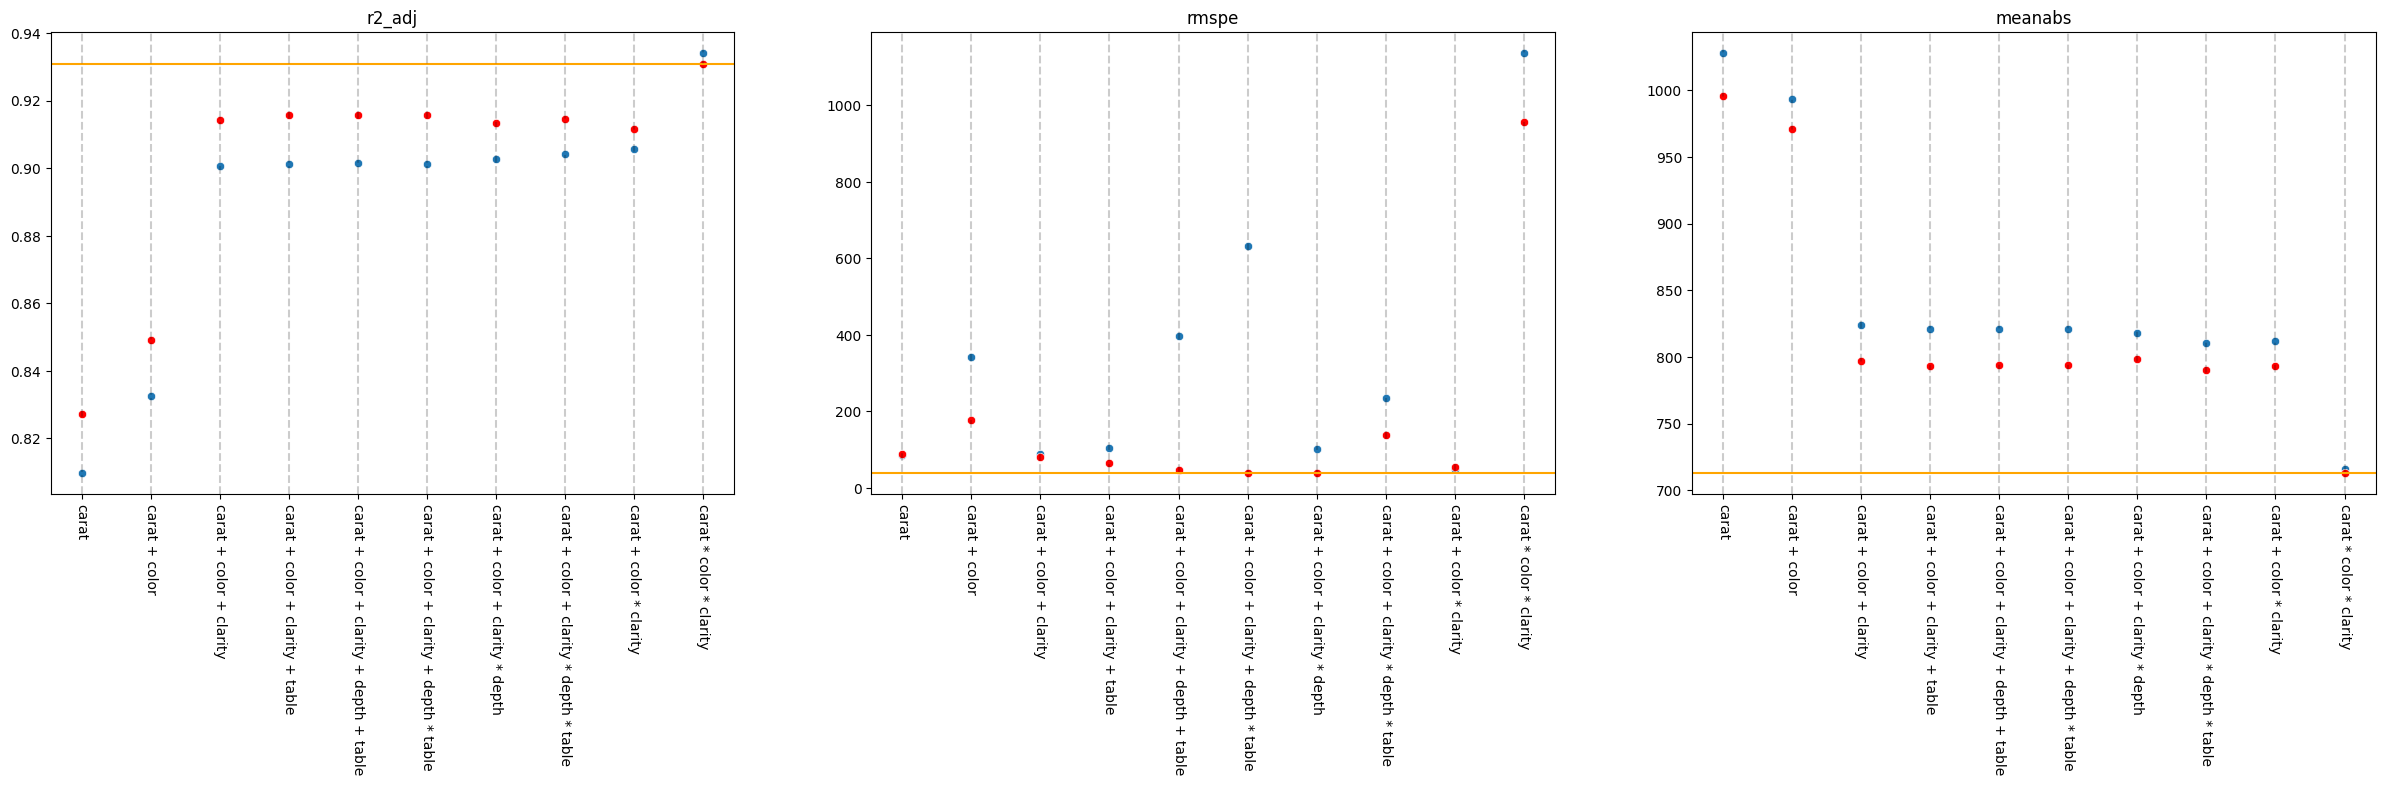

In [6]:
#  fit simple linear models
models_f_linear = [
    'price ~ carat',
    'price ~ carat + color',
    'price ~ carat + color + clarity',
    'price ~ carat + color + clarity + table',


    'price ~ carat + color * clarity',
    'price ~ carat * color * clarity',

    

    'price ~ carat + color + clarity * depth',

    'price ~ carat + color + clarity + depth + table',
    'price ~ carat + color + clarity + depth * table',
    'price ~ carat + color + clarity * depth * table',
    

]

# Initialize and compare the models
models, results = fit_and_analyze(models_f_linear, train_df, validation_df, dependent_variable = 'price')
compare_models(results, n = 5)

Top 10 models and their degrees of freedom according to the r2_adj metric
                                                     r2_adj_validate    df
log_carat * color_num * clarity_num * depth * table         0.981268  31.0
log_carat * color_num * clarity_num * depth                 0.981016  15.0
log_carat * color_num * clarity_num                         0.980814   7.0
log_carat + color_num * clarity_num                         0.979864   4.0
log_carat + color_num + clarity_num * depth * table         0.979379   9.0
log_carat + color_num + clarity_num + depth * table         0.979298   6.0
log_carat + color_num + clarity_num + depth + table         0.979251   5.0
log_carat + color_num + clarity_num * depth                 0.978795   5.0
log_carat + color_num + clarity_num + depth                 0.978772   4.0
log_carat + color_num + clarity_num                         0.978771   3.0
Top 10 models and their degrees of freedom according to the rmspe metric
                            

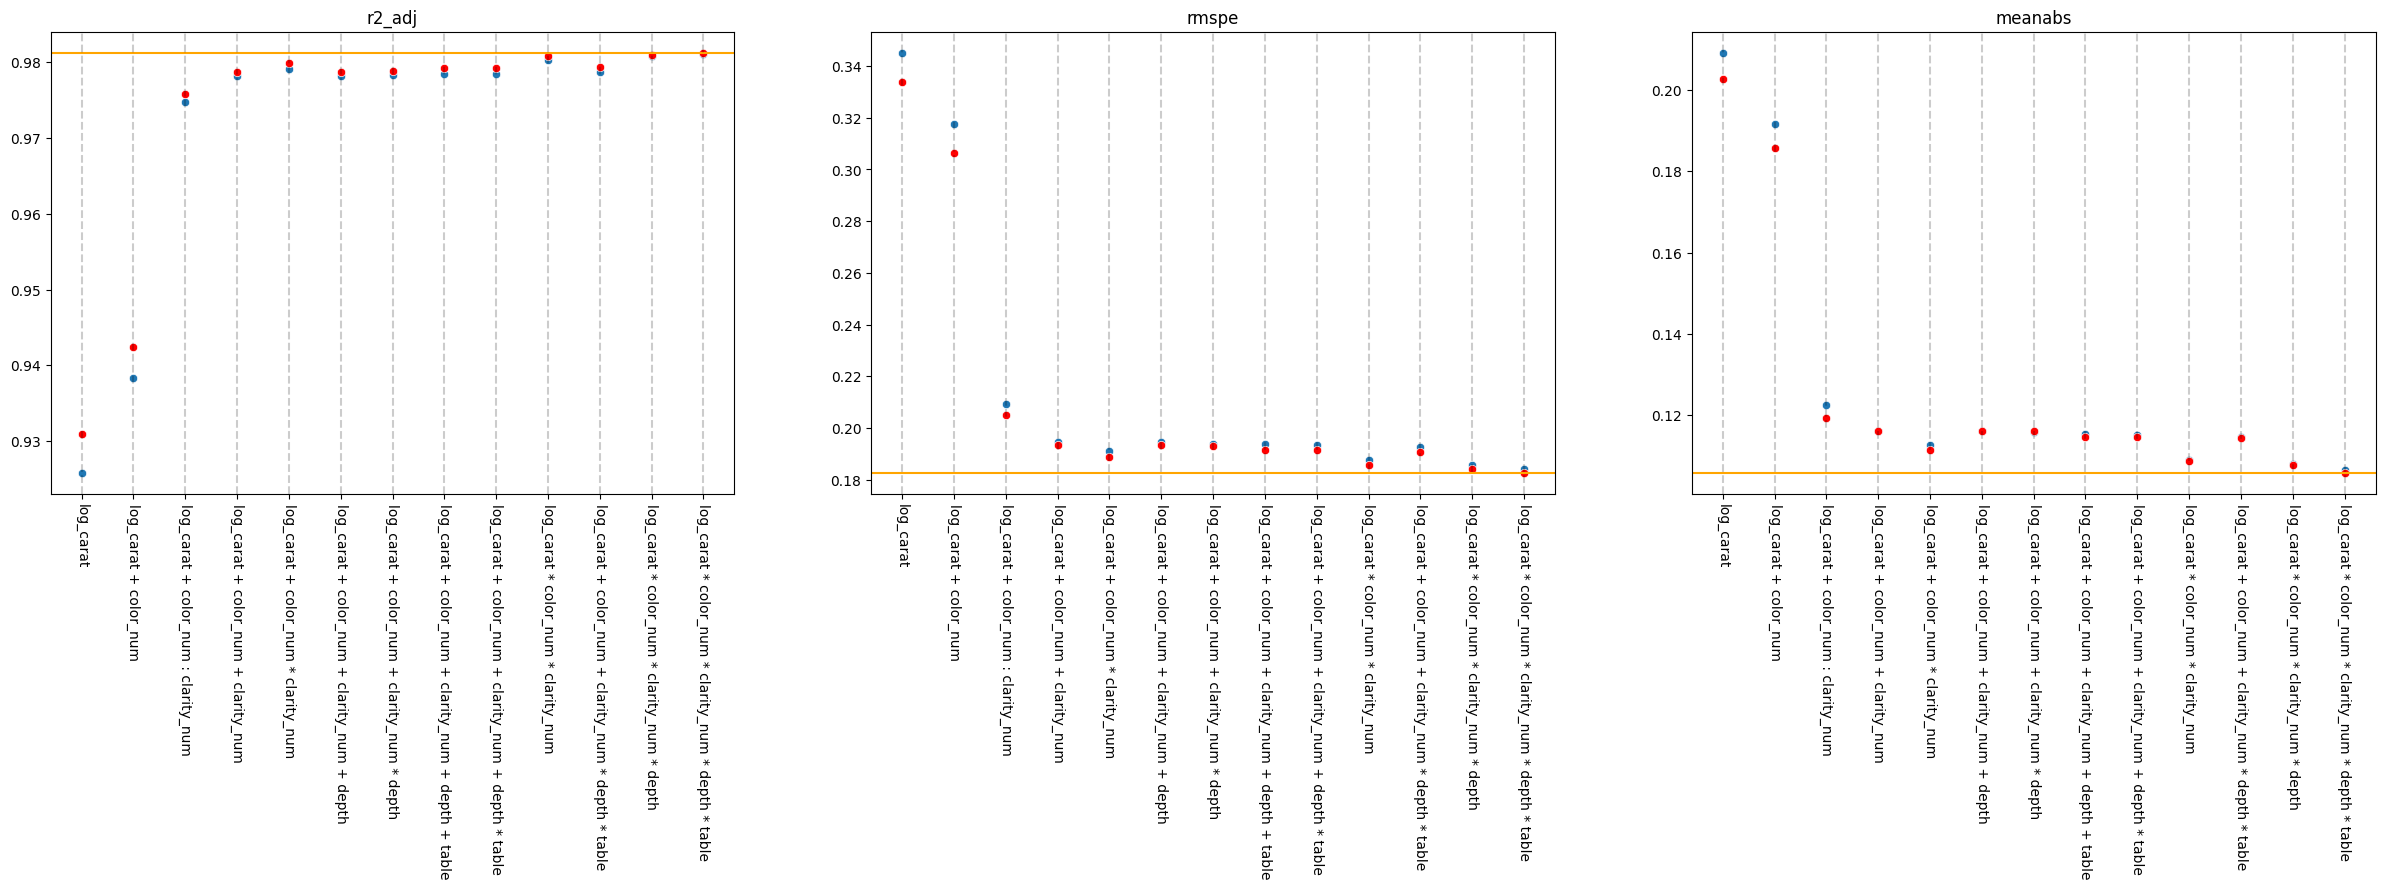

In [7]:
#  fit simple linear models
models_f = [
    'log_price ~ log_carat',
    'log_price ~ log_carat + color_num',
    'log_price ~ log_carat + color_num + clarity_num',
    'log_price ~ log_carat + color_num : clarity_num',
    'log_price ~ log_carat + color_num * clarity_num',
    'log_price ~ log_carat * color_num * clarity_num',

    'log_price ~ log_carat * color_num * clarity_num * depth',
    'log_price ~ log_carat * color_num * clarity_num * depth * table',

    
    'log_price ~ log_carat + color_num + clarity_num + depth',
    'log_price ~ log_carat + color_num + clarity_num * depth',

    'log_price ~ log_carat + color_num + clarity_num + depth + table',
    'log_price ~ log_carat + color_num + clarity_num + depth * table',
    'log_price ~ log_carat + color_num + clarity_num * depth * table',
]

# Initialize and compare the models
models, results = fit_and_analyze(models_f, train_df, validation_df, dependent_variable = 'log_price')
compare_models(results, n = 10)

Top 5 models and their degrees of freedom according to the r2_adj metric
                                                     r2_adj_validate     df
log_carat + color * clarity                                 0.983009   56.0
log_carat * color * clarity                                 0.982912  111.0
log_carat + color + clarity + log_depth + log_table         0.981950   16.0
log_carat + color + clarity * log_table + log_depth         0.981773   23.0
log_carat + color + clarity                                 0.981593   14.0
Top 5 models and their degrees of freedom according to the rmspe metric
                                                     rmspe_validate     df
log_carat * color * clarity                                0.167956  111.0
log_carat + color * clarity                                0.171791   56.0
log_carat * color * clarity * log_depth + log_table        0.178474  217.0
log_carat * color * clarity * log_depth                    0.178573  216.0
log_carat + color + clar

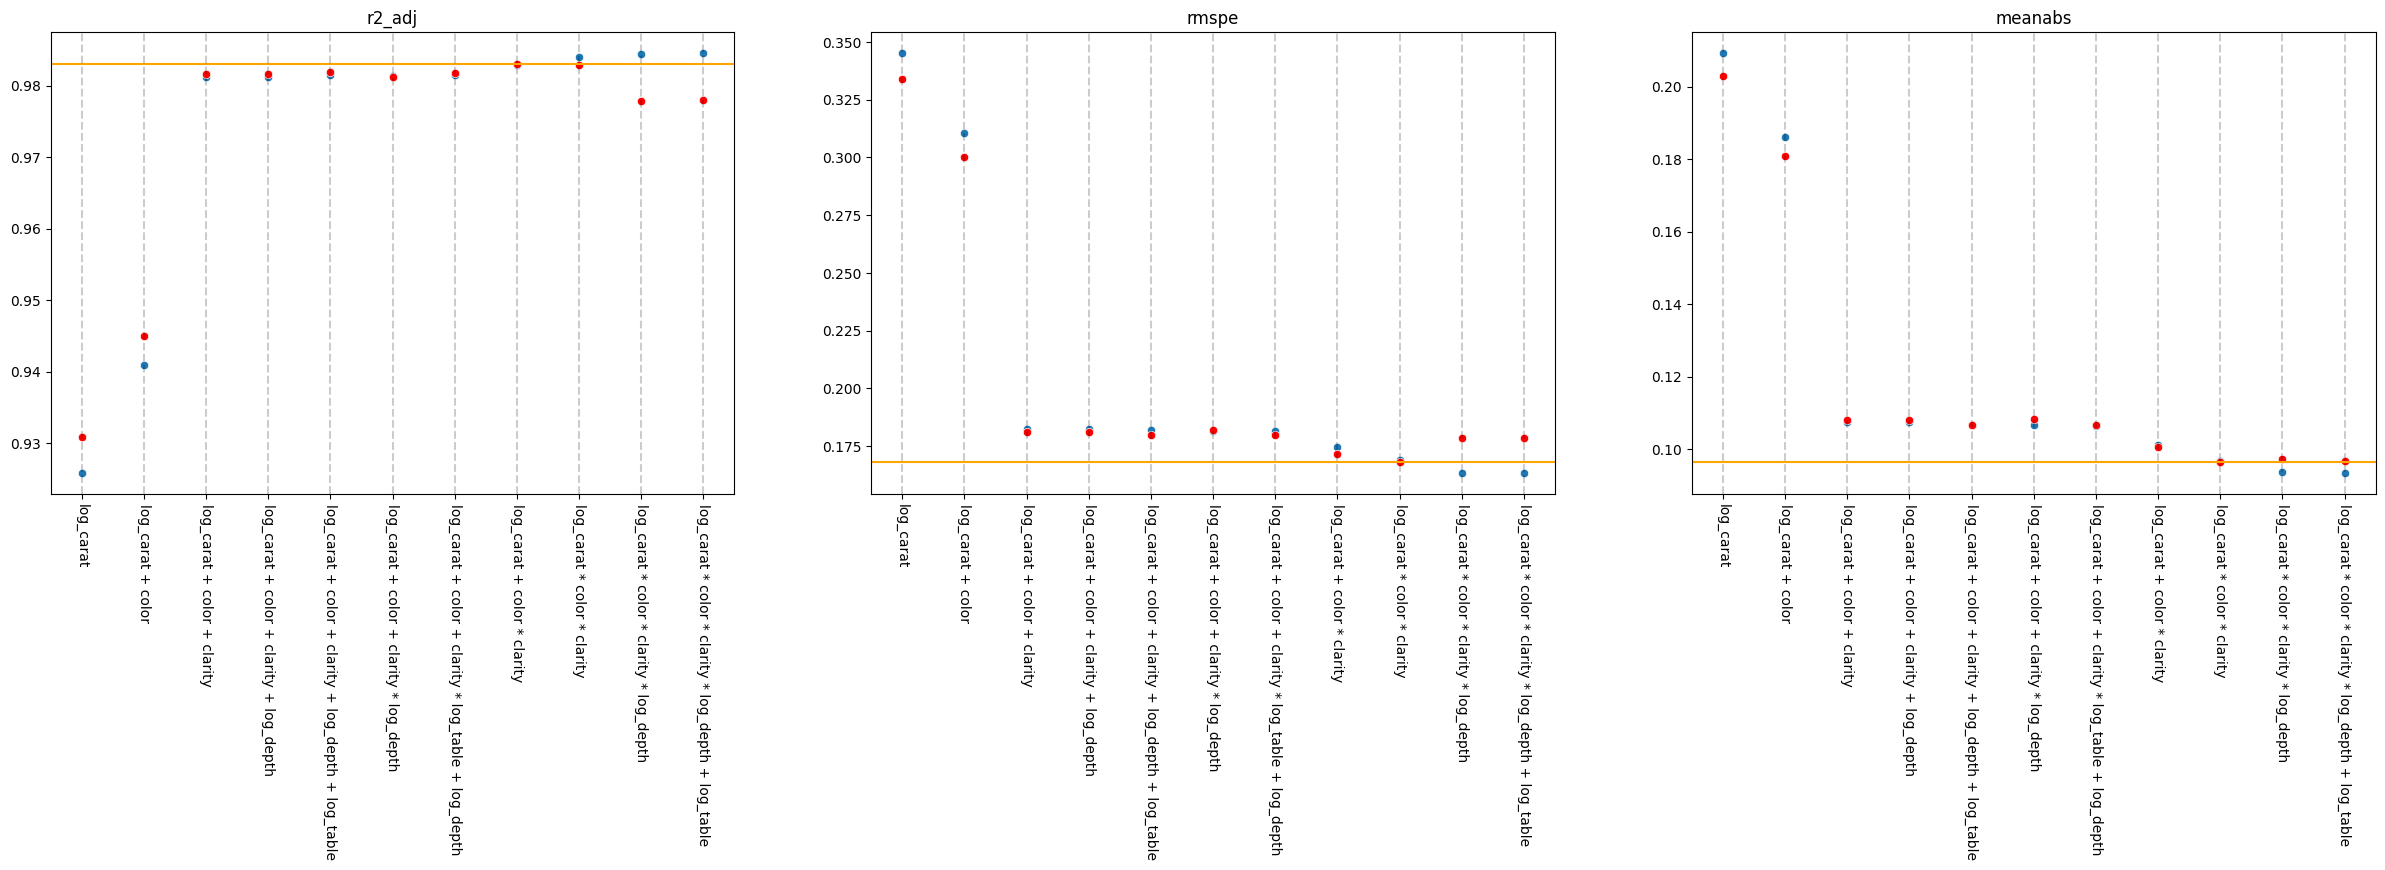

In [8]:
#  fit simple linear models
models_f_loglinear = [
    'log_price ~ log_carat',
    'log_price ~ log_carat + color',
    'log_price ~ log_carat + color + clarity',
    'log_price ~ log_carat + color * clarity',
    'log_price ~ log_carat * color * clarity',    

    'log_price ~ log_carat * color * clarity * log_depth',
    'log_price ~ log_carat * color * clarity * log_depth + log_table',

    
    'log_price ~ log_carat + color + clarity + log_depth',
    'log_price ~ log_carat + color + clarity * log_depth',

    'log_price ~ log_carat + color + clarity + log_depth + log_table',
    'log_price ~ log_carat + color + clarity * log_table + log_depth',
]

# Initialize and compare the models
models_loglinear, results = fit_and_analyze(models_f_loglinear, train_df, validation_df, dependent_variable = 'log_price')
compare_models(results, n = 5)

In [9]:
# Inspect the significance of the degrees of freedom in a model of interest
def number_non_significant_df(formula, models, models_f, alpha = 0.05):
    m = models[models_f.index(formula)]
    print('Number of non-significant degrees of freedom in:')
    print(f' {formula} :') 
    print(f'{(m.pvalues.to_numpy() > alpha).sum()} / {m.pvalues.size - 1}')


number_non_significant_df('log_price ~ log_carat + color * clarity', models_loglinear, models_f_loglinear)

Number of non-significant degrees of freedom in:
 log_price ~ log_carat + color * clarity :
24 / 56


We have 3 interesting candidate models

1. *log_carat * color * clarity*, which is consistently ranked the first all three metrics. It has however a lot of DoF (109) and is often only a marginal improvement over the second ranked model

2. *log_carat + color * clarity*, has way less DoF (55) and is is always among the top 3 models

3. *log_carat + color + clarity + log_depth * log_table*, has only 17 DoF and is always among the top 5 models

Furthermore, not all the predictors in *'log_price ~ log_carat + color * clarity' *are significant. Setting $\alpha = 0.05$, we find that 22 of the fitted parameters are not significant. We can try to reduce the number of degrees of freedom in 2 ways: 

1. 1. Defining a single categorical variable that uniquely identifies color-clarity groups
2. Using the numerical quantities instead of the categorical ones 

Let's start exploring the first option

Top 5 models and their degrees of freedom according to the r2_adj metric
                                                   r2_adj_validate     df
log_carat + color_clarity + log_depth + log_table         0.983279   58.0
log_carat + color_clarity + log_table                     0.983218   57.0
log_carat + color * clarity                               0.983009   56.0
log_carat + color_clarity + log_depth                     0.983001   57.0
log_carat * color * clarity                               0.982912  111.0
Top 5 models and their degrees of freedom according to the rmspe metric
                                                   rmspe_validate     df
log_carat * color * clarity                              0.167956  111.0
log_carat + color_clarity + log_depth + log_table        0.170712   58.0
log_carat + color_clarity + log_table                    0.170963   57.0
log_carat + color_clarity + log_depth                    0.171766   57.0
log_carat + color * clarity                   

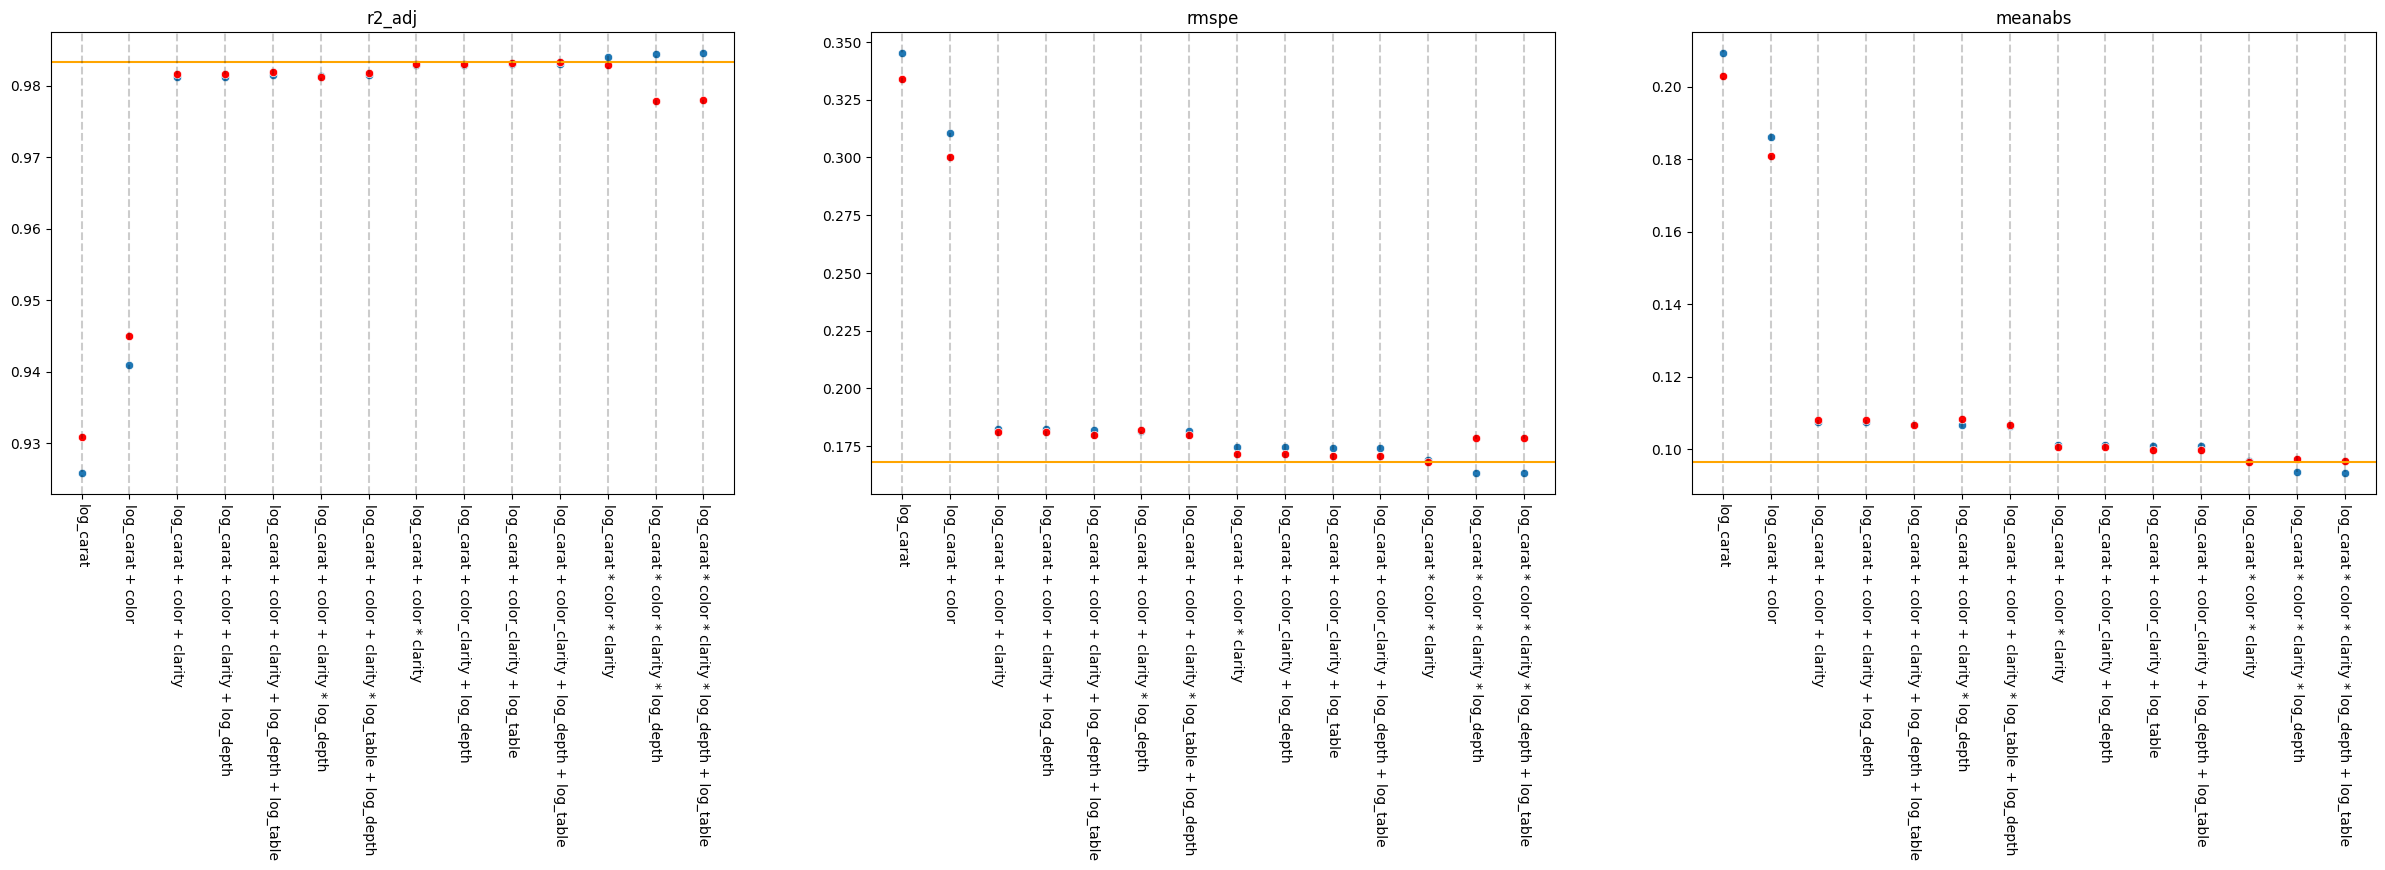

In [10]:
models_f_loglinear.extend(
    [
        'log_price ~ log_carat + color_clarity + log_depth',
        'log_price ~ log_carat + color_clarity + log_table',
        'log_price ~ log_carat + color_clarity + log_depth + log_table',
    ]
)


# Initialize and compare the models
models_loglinear, results = fit_and_analyze(models_f_loglinear, train_df, validation_df, dependent_variable = 'log_price')
compare_models(results, n = 5)

# Assess degrees of freedom of one of the models
print('\n')
number_non_significant_df('log_price ~ log_carat + color_clarity + log_depth + log_table', models_loglinear, models_f_loglinear)

The new model *log_price ~ log_carat + color_clarity + log_depth * log_table :* is now ranked among the best model according to all the metrics and all of the parameters fitted are significant with significance level $\alpha = 0.05$

We can also explore the second option, converting the categorical variables into numerical ones: 

Top 5 models and their degrees of freedom according to the r2_adj metric
                                                     r2_adj_validate    df
log_carat * color_num * clarity_num * depth * table         0.981268  31.0
log_carat * color_num * clarity_num * depth                 0.981016  15.0
log_carat * color_num * clarity_num                         0.980814   7.0
log_carat + color_num * clarity_num                         0.979864   4.0
log_carat + color_num + clarity_num * depth * table         0.979379   9.0
Top 5 models and their degrees of freedom according to the rmspe metric
                                                     rmspe_validate    df
log_carat * color_num * clarity_num * depth * table        0.182743  31.0
log_carat * color_num * clarity_num * depth                0.184206  15.0
log_carat * color_num * clarity_num                        0.185645   7.0
log_carat + color_num * clarity_num                        0.188908   4.0
log_carat + color_num + clarity_num

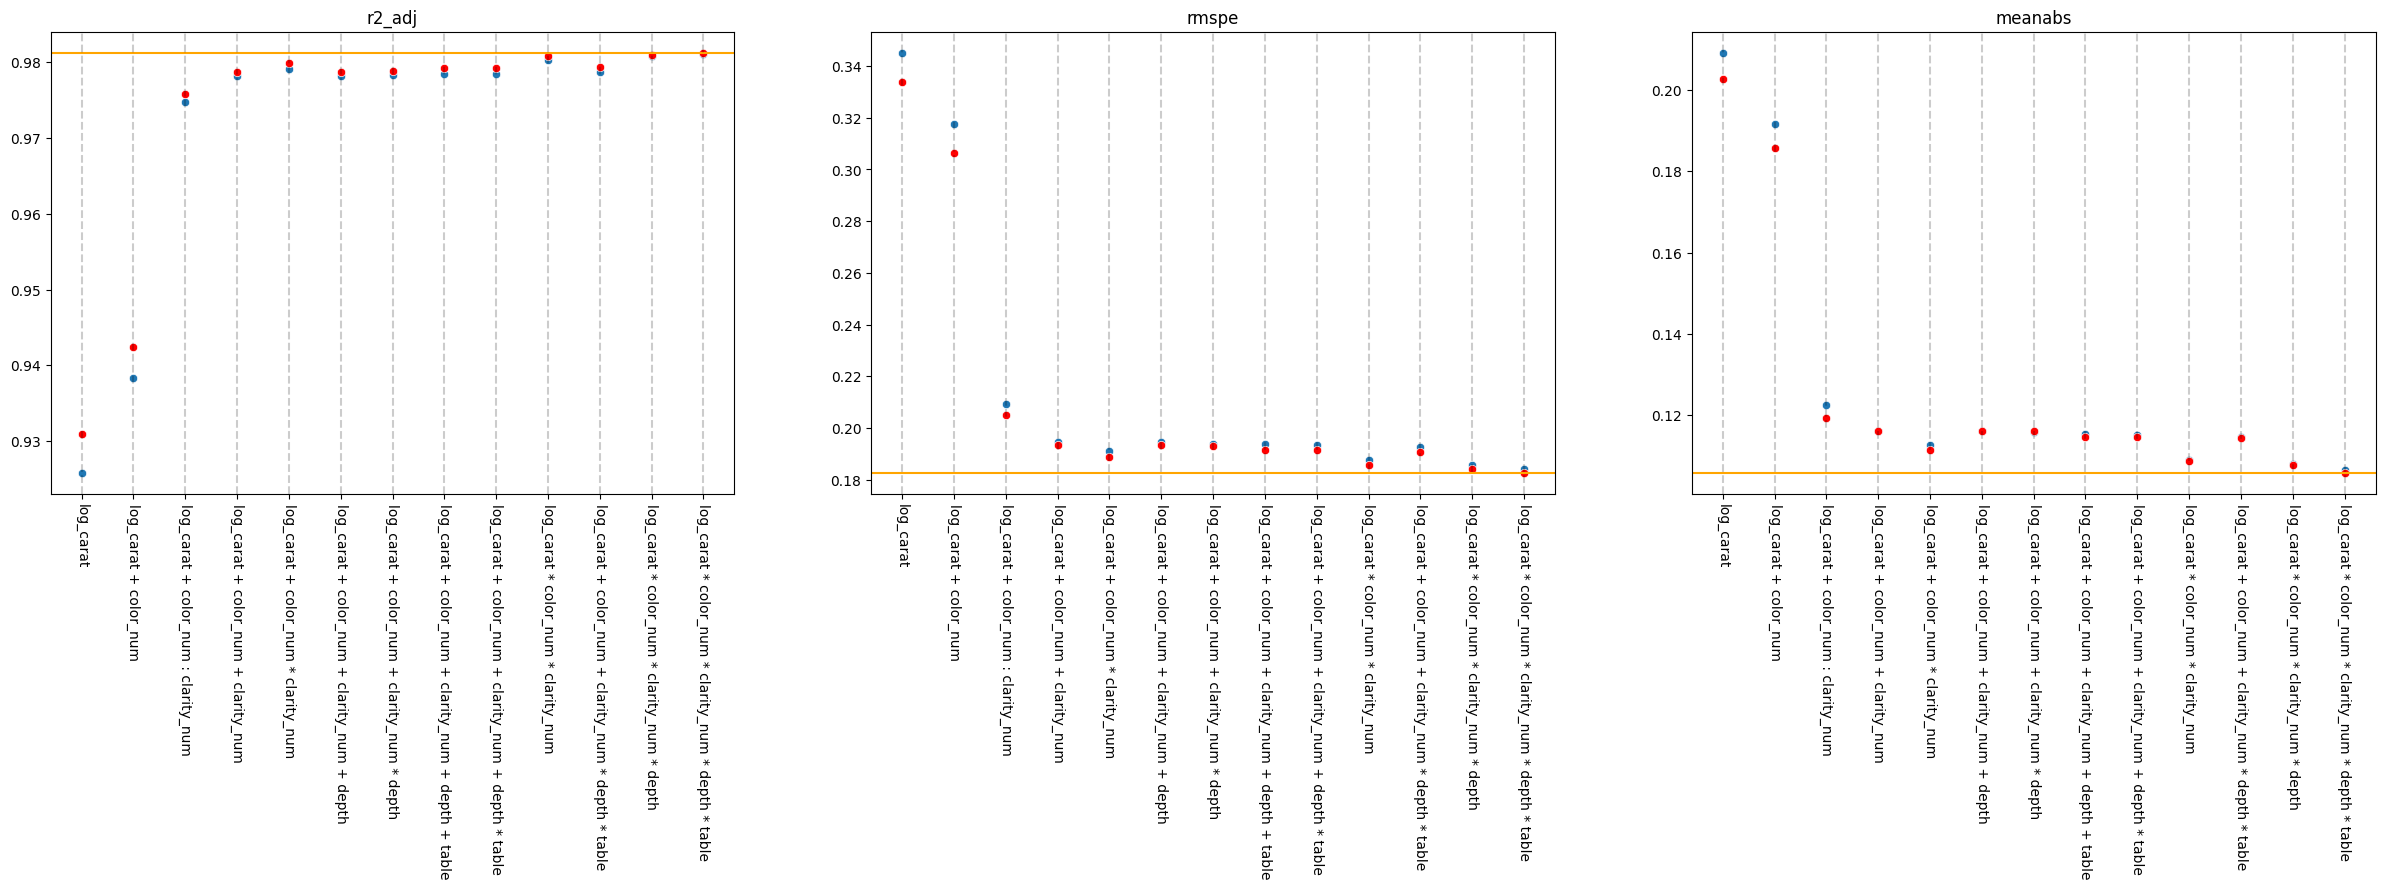

In [11]:
models_f_numerical = [
    'log_price ~ log_carat',
    'log_price ~ log_carat + color_num',
    'log_price ~ log_carat + color_num + clarity_num',
    'log_price ~ log_carat + color_num : clarity_num',
    'log_price ~ log_carat + color_num * clarity_num',
    'log_price ~ log_carat * color_num * clarity_num',

    'log_price ~ log_carat * color_num * clarity_num * depth',
    'log_price ~ log_carat * color_num * clarity_num * depth * table',

    
    'log_price ~ log_carat + color_num + clarity_num + depth',
    'log_price ~ log_carat + color_num + clarity_num * depth',

    'log_price ~ log_carat + color_num + clarity_num + depth + table',
    'log_price ~ log_carat + color_num + clarity_num + depth * table',
    'log_price ~ log_carat + color_num + clarity_num * depth * table',
]

# Initialize and compare the models
models_numerical, results = fit_and_analyze(models_f_numerical, train_df, validation_df, dependent_variable = 'log_price')
compare_models(results, n = 5)

These models have less degrees of freedom but they also underperform the previous model *log_price ~ log_carat + color_clarity + depth * table :*. 

Furthermore, the model *log_price ~ log_carat + color_clarity + depth * table :* is also interpretable. It implies that the price of a diamond can be computed with a simple formula:

$$price = const \times mul(col, clar)\times (carat) ^\alpha (depth )^\beta( table)^\gamma$$

With muls (col, cla) being a unique multiplies associated to a specific color and clarity. The fitted parameters are printed/plotted below

Final fitted parameters
const 46339.3
alpha 1.89
beta -0.27
gamma -0.36


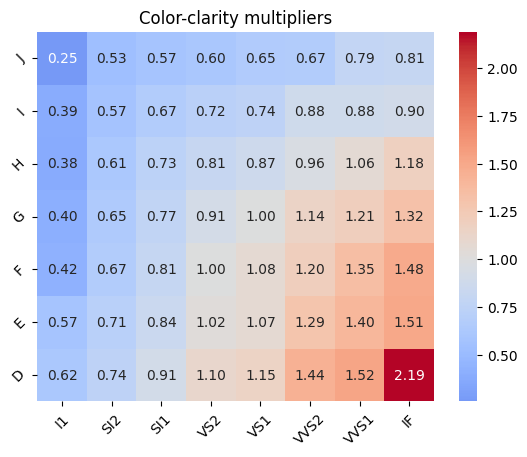

In [12]:
# Format parameters in a more interpretable way and print/plot the parameters
m = models_loglinear[models_f_loglinear.index('log_price ~ log_carat + color_clarity + log_depth + log_table')]

multipliers = np.zeros((7, 8))
for name, value in m.params.items(): 
    if '.' in name:
        col, cla = name.split('.')[1][:-1].split('_')
        multipliers[
            colors_numerical_values[col], clarity_numerical_values[cla]
        ] = value

final_params = {}
final_params['const']       = np.exp(m.params['Intercept'])
final_params['alpha']       = m.params['log_carat']
final_params['beta']        = m.params['log_depth']
final_params['gamma']       = m.params['log_table']
final_params['multipliers'] = np.exp(multipliers)

# Shift the multipliers and constant
final_params['multipliers'] /= final_params['multipliers'][3, 4]
final_params['const']       *= final_params['multipliers'][3, 4]

# Print fitted values
print('Final fitted parameters')
for key, value in final_params.items():
    if key != 'multipliers':
        print(key,np.round(value, 2))

# Print the multipliers
heatmap = sns.heatmap(
    final_params['multipliers'], 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",

    center = 1.)

col_ordered_names = list(colors_numerical_values.keys() )
cla_ordered_names = list(clarity_numerical_values.keys())


_ = plt.yticks(.5+np.arange(len(col_ordered_names)), col_ordered_names, rotation = 45)
_ = plt.xticks(.5+np.arange(len(cla_ordered_names)), cla_ordered_names, rotation = 45)
_ = plt.title('Color-clarity multipliers')


In [13]:
# Check consistenncy of the model and formula
data['formula'] = data.apply(lambda x:
           final_params['const']*x['carat']**final_params['alpha']* \
            x['depth']**final_params['beta']*\
            x['table']**final_params['gamma']*\
            final_params['multipliers'][ 
                colors_numerical_values[x['color']], 
                clarity_numerical_values[x['clarity']]
                ], 
            axis = 1)
data['model'] = np.exp(m.predict(data))
print('Check consistency: ', np.allclose(data['model'], data['formula']))

Check consistency:  False


## Neural network
Don Francesco seems to care a lot about interpretability, so he probably would not like an approach involving nerual networks. 

Neural Networks are very powerful but generaly not very interpretable. We can however try to implement a neural network model to compare the perfomrmances to the linear models we fitted

In [14]:
def rmspe(y_true, y_pred):
    # Ensure the inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the RMSPE
    percentage_errors = (y_true - y_pred) / y_true
    rmspe_value = np.sqrt(np.mean(percentage_errors ** 2))
    
    return rmspe_value

In [15]:
# convert the train and test dataset into torch tensors retaining only log_carat  color clarity 
train_set           = convert_to_torch_carat_color(train_df)
validation_set      = convert_to_torch_carat_color(validation_df)
test_set            = convert_to_torch_carat_color(test_df)
print('Number of features in the train set: ', train_set.tensors[0].shape[1])

# define and initialize the model
hidden_dim = 100
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        # self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
model = Model(train_set.tensors[0].shape[1], hidden_dim)

# define training loop
def train(model, train_set, validation_set, epochs, lr, optimizer_class, criterion):
    log_loss_train = list(); log_loss_validation = list()
    optimizer = optimizer_class(model.parameters(), lr = lr)

    for e in range(epochs):
        optimizer.zero_grad()
        y_pred = model(train_set.tensors[0])
        loss = criterion(y_pred.squeeze(), train_set.tensors[1].squeeze())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            pred_test = model(validation_set.tensors[0])
            loss_test = criterion(pred_test.squeeze(), validation_set.tensors[1].squeeze())
            log_loss_validation.append(loss_test.item())
            log_loss_train.append(loss.item())
        

        if e % (epochs//10) == 0: print(f'Epoch {e+1}/{epochs}, Loss: {loss.item()}')
        log_loss_train.append(loss.item())  

    return log_loss_train, log_loss_validation

def compute_metrics(model, data):
    with torch.no_grad():
        y_pred = model(data.tensors[0]).squeeze()
    y_true = data.tensors[1].squeeze()
    with torch.no_grad():
        results = {}
        results['r2']        = r_squared           (y_pred, y_true)
        # results['r2_adj']    = adjusted_r_squared  (y_pred, y_true, sum([p.numel() for p in model.parameters() if p.requires_grad]))
        results['meanabs']   = meanabs             (y_pred, y_true)
        results['rmspe']     = rmspe               (y_pred, y_true)
    # results['rmedspe']   = [rmedspe              (m.predict(df), df[dependent_variable]) for m in models]

    return results

Number of features in the train set:  16


Epoch 1/1000, Loss: 61.29520797729492
Epoch 101/1000, Loss: 0.018948519602417946
Epoch 201/1000, Loss: 0.01671813614666462
Epoch 301/1000, Loss: 0.01583925448358059
Epoch 401/1000, Loss: 0.01514173299074173
Epoch 501/1000, Loss: 0.014617342501878738
Epoch 601/1000, Loss: 0.014184731990098953
Epoch 701/1000, Loss: 0.013852753676474094
Epoch 801/1000, Loss: 0.013560719788074493
Epoch 901/1000, Loss: 0.01334031205624342
Results train:  {'r2': 0.987059741280973, 'meanabs': 0.08942702, 'rmspe': 0.015430225}
Results validation:  {'r2': 0.9855689378455281, 'meanabs': 0.09512698, 'rmspe': 0.016502274}
R2 loglinear vs nn:  0.9967


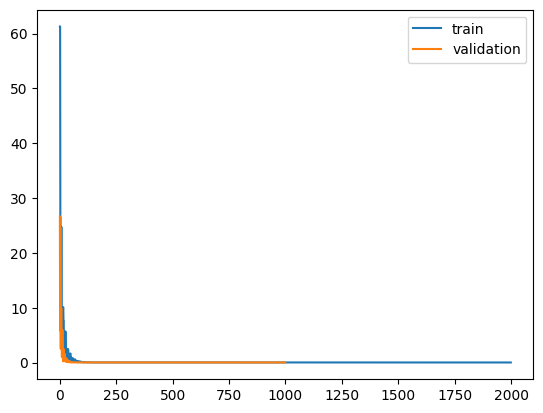

In [16]:
# train the model
train_kwargs = {
    'epochs': 1000,
    'train_set': train_set,
    'validation_set' : validation_set,
    'lr': 1e-1,
    'optimizer_class': torch.optim.Adam,
    'criterion': nn.MSELoss()
}
train_loss, test_loss = train(model, **train_kwargs)
plt.plot(train_loss, label = 'train')
plt.plot(test_loss, label = 'validation')
_ = plt.legend()


results_train= compute_metrics(model, train_set)
results_validation = compute_metrics(model, validation_set)

# Compare the predictions of the loglinear and nn models
with torch.no_grad():
    nn_pred = model(validation_set.tensors[0]).squeeze().detach()
r2 = round(r_squared(nn_pred, m.predict(validation_df)), 4)

print('Results train: ', results_train)
print('Results validation: ', results_validation)
print('R2 loglinear vs nn: ', r2)


We can now repeat the same procedure but retaining all the variables

Number of features in the train set:  16
Epoch 1/1000, Loss: 64.515380859375
Epoch 101/1000, Loss: 0.018705761060118675
Epoch 201/1000, Loss: 0.01603155955672264
Epoch 301/1000, Loss: 0.015227261930704117
Epoch 401/1000, Loss: 0.014669576659798622
Epoch 501/1000, Loss: 0.014264900237321854
Epoch 601/1000, Loss: 0.01398954913020134
Epoch 701/1000, Loss: 0.013759453780949116
Epoch 801/1000, Loss: 0.01356923021376133
Epoch 901/1000, Loss: 0.013433095999062061
Results train:  {'r2': 0.9869222398847342, 'meanabs': 0.0894148, 'rmspe': 0.015552025}
Results validation:  {'r2': 0.9854705249890685, 'meanabs': 0.0950095, 'rmspe': 0.016545707}
R2 loglinear vs nn:  0.9969


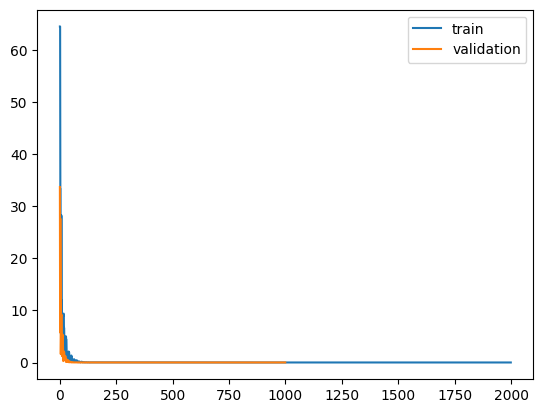

In [17]:
# get the data in torch format but retaining all the variables
training_data   = convert_to_torch_carat_color(train_df)
validation_data = convert_to_torch_carat_color(validation_df)
print('Number of features in the train set: ', training_data.tensors[0].shape[1])

# reinitialize the model
model = Model(train_set.tensors[0].shape[1], hidden_dim)

# train the model
train_kwargs = {
    'epochs': 1000,
    'train_set': train_set,
    'validation_set' : validation_set,
    'lr': 1e-1,
    'optimizer_class': torch.optim.Adam,
    'criterion': nn.MSELoss()
}
train_loss, validation_loss = train(model, **train_kwargs)
plt.plot(train_loss, label = 'train')
plt.plot(validation_loss, label = 'validation')
_ = plt.legend()


results_train= compute_metrics(model, train_set)
results_validation = compute_metrics(model, validation_set)

# Compare the predictions of the loglinear and nn models
with torch.no_grad():
    nn_pred = model(validation_set.tensors[0]).squeeze().detach()
r2 = round(r_squared(nn_pred, m.predict(validation_df)), 4)

print('Results train: ', results_train)
print('Results validation: ', results_validation)
print('R2 loglinear vs nn: ', r2)

The neural networks have comparable results when they have access only to the variables "carat", "color", "clarity" and when they have access to the full dataset. 

## Neural Network Error
Don Francesco is ultimately interested in trading the diamonds. It would probably be extremely valuable for him to have a confidence level of the price prediction of the model. 

After all, he is an expert collector and could use the variability of diamond prices to profit. <br>
(The price of the diamond is likely influenced by external factors, like the economic conditions, the willingness of the client to sell, etc)

To this end, we can devise a simmple model that predicts both the mean and the variance of the predicted data. 

Under the assumptions of the following noise model of the data: 
$$y = f_\theta(x) + \sigma_\theta(x) \epsilon$$
With $f_\theta$ being a learnable function with learnable parameters $\theta$ and a noise $\epsilon$ sampled from a normal distribution. The noise level $\sigma_\theta(x)$ is also learnable and can depend on the set of predictors x <br>
We can therefore compute the log likelihood of the model: 
$$L = \log p(y|x) = log [\prod_i \frac{1}{\sqrt{2 \pi } \sigma_\theta(x_i)}e^{\frac{(y_i - f_\theta(x_i))^2}{2\sigma^2_\theta(x_i)}}]$$

Maximizing this function is equivalent to maximizing: 
$$\sum_i( \frac{1}{2} (\frac{f_\theta(x_i) - y_i}{\sigma_\theta(x_i)})^2 + \log \sigma_\theta (x_i) )$$

We will train a newral network to predict $f_\theta(x_i)$ and $log(\sigma_\theta(x_i))$

In [56]:
# import the data
training_data   = convert_to_torch_carat_color(train_df)
validation_data       = convert_to_torch_carat_color(validation_df)
print('Number of features in the train set: ', training_data.tensors[0].shape[1])

# redefine and initialize the model
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mean = self.fc2(x)
        log_std = self.fc3(x)
        return mean, log_std

# define custom loss we just derived
def likelihood_loss(y_pred, y_true, log_std):
    loss =  ((y_pred - y_true)/log_std.exp())**2 + 2*log_std
    return loss.mean()

# rewrite training loop
def train(model, training_data, epochs, lr, optimizer_class, criterion):
    model.train()
    print(training_data.tensors[0].shape)
    log_loss_train = list(); log_loss_test = list()
    optimizer = optimizer_class(model.parameters(), lr = lr)

    for e in range(epochs):
        optimizer.zero_grad()
        y_pred, log_std = model(training_data.tensors[0])
        loss = likelihood_loss(
            y_pred  = y_pred.squeeze(), 
            y_true  = training_data.tensors[1].squeeze(), 
            log_std = log_std.squeeze()
        )
        loss.backward()
        optimizer.step()
        log_loss_train.append(loss.item())

        with torch.no_grad():
            pred_test, log_std_test = model(test_set.tensors[0])
            loss_test = criterion(pred_test.squeeze(), test_set.tensors[1].squeeze(), log_std_test)
            log_loss_test.append(loss_test.item())

        if e % (epochs//10) == 0: print(f'Epoch {e+1}/{epochs}, Loss: {loss.item()}')
    
    return log_loss_train, log_loss_test
    

Number of features in the train set:  16


torch.Size([2993, 16])
Epoch 1/800, Loss: 61.14328384399414
Epoch 81/800, Loss: -0.5215662121772766
Epoch 161/800, Loss: -1.8041032552719116
Epoch 241/800, Loss: 10.45398235321045
Epoch 321/800, Loss: 4.59529447555542
Epoch 401/800, Loss: -1.7215335369110107
Epoch 481/800, Loss: 1.3733532428741455
Epoch 561/800, Loss: -2.8219666481018066
Epoch 641/800, Loss: -2.9233694076538086
Epoch 721/800, Loss: -2.9783473014831543


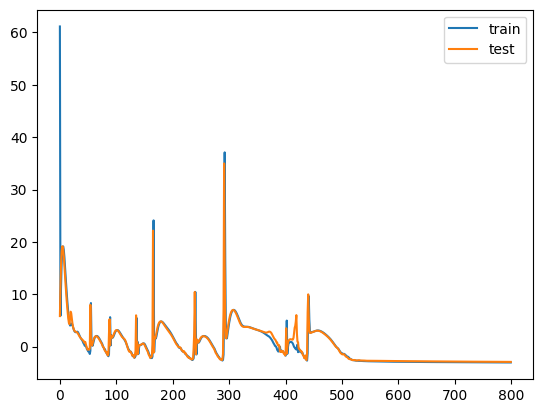

In [ ]:
# train the model
hidden_dim = 100
model = Model(training_data.tensors[0].shape[1], hidden_dim)

train_kwargs = {
    'model' : model,
    'training_data': training_data,
    'epochs': 1100,
    'lr': 1e-1,
    'optimizer_class': torch.optim.Adam,
    'criterion': likelihood_loss
}
train_loss, test_loss = train(**train_kwargs)
plt.plot(train_loss, label = 'train')
plt.plot(test_loss, label = 'test')
_ = plt.legend()

In [ ]:
def plot_group(mean, std, x_train, x_validation, y_train, y_validation, selected_clarity, selected_color, ax, plot_legend):

    # convert to exponential for plotting
    x_train, y_train = x_train.exp(), y_train.exp()
    x_validation, y_validation = x_validation.exp(), y_validation.exp()

    # plot w/wo labels
    if plot_legend:
        sns.scatterplot (x = x_train[:, -1], y = y_train                , ax = ax, label = 'Train data')
        sns.scatterplot (x = x_validation [:, -1], y = y_validation                 , ax = ax, label = 'Validation data', c = 'green')
        sns.lineplot    (x = x_train[:, -1], y = mean.exp()             , ax = ax, label = 'Predicted price +/- $2\sigma$', c = 'red')
    else: 
        sns.scatterplot (x = x_train[:, -1], y = y_train                , ax = ax)
        sns.scatterplot (x = x_validation [:, -1], y = y_validation                 , ax = ax, c = 'green')
        sns.lineplot    (x = x_train[:, -1], y = mean.exp()             , ax = ax, c = 'red')

    # plot standard deviations
    sns.lineplot    (x = x_train[:, -1], y = (mean + 2*std).exp()   , ax = ax, c = 'red')
    sns.lineplot    (x = x_train[:, -1], y = (mean - 2*std).exp()   , ax = ax, c = 'red')

    # Print title and axis labels
    ax.set_title(f'Group = {selected_clarity},  {selected_color}')
    ax.set_xlabel('Carat')
    ax.set_ylabel('Price')

In [ ]:
# Check the data split and indexing of the colors/clarity data

# training_data   = convert_to_torch_carat_color(train_df)
# validation_data       = convert_to_torch_carat_color(test_df)
# validation_data = convert_to_torch_carat_color(validation_df)

# color_idx, clarity_idx = group_indices('D', 'SI1')
# print('index color E', color_idx)
# print('index clarity SI2', clarity_idx)

# x_train, y_train    = sorted_group_points(color_idx, clarity_idx, training_data)
# x_test, y_test      = sorted_group_points(color_idx, clarity_idx, validation_data)
# x_val, y_val        = sorted_group_points(color_idx, clarity_idx, validation_data)
# print(x_test.shape, y_test.shape)
# print(x_train.shape, y_train.shape)
# print(x_val.shape, y_val.shape)

# print(x_test.shape[0] + x_train.shape[0] + x_val.shape[0], y_test.shape[0] + y_train.shape[0] + y_val.shape[0])

# group_numerosity = data.groupby(['color', 'clarity']).count()['carat'] 
# print(group_numerosity[('D', 'SI1')])

0 0 0 E SI1
1 1 0 E VS2
2 0 1 F VS2
3 1 1 G VS1
4 0 2 G VS2
5 1 2 H SI1


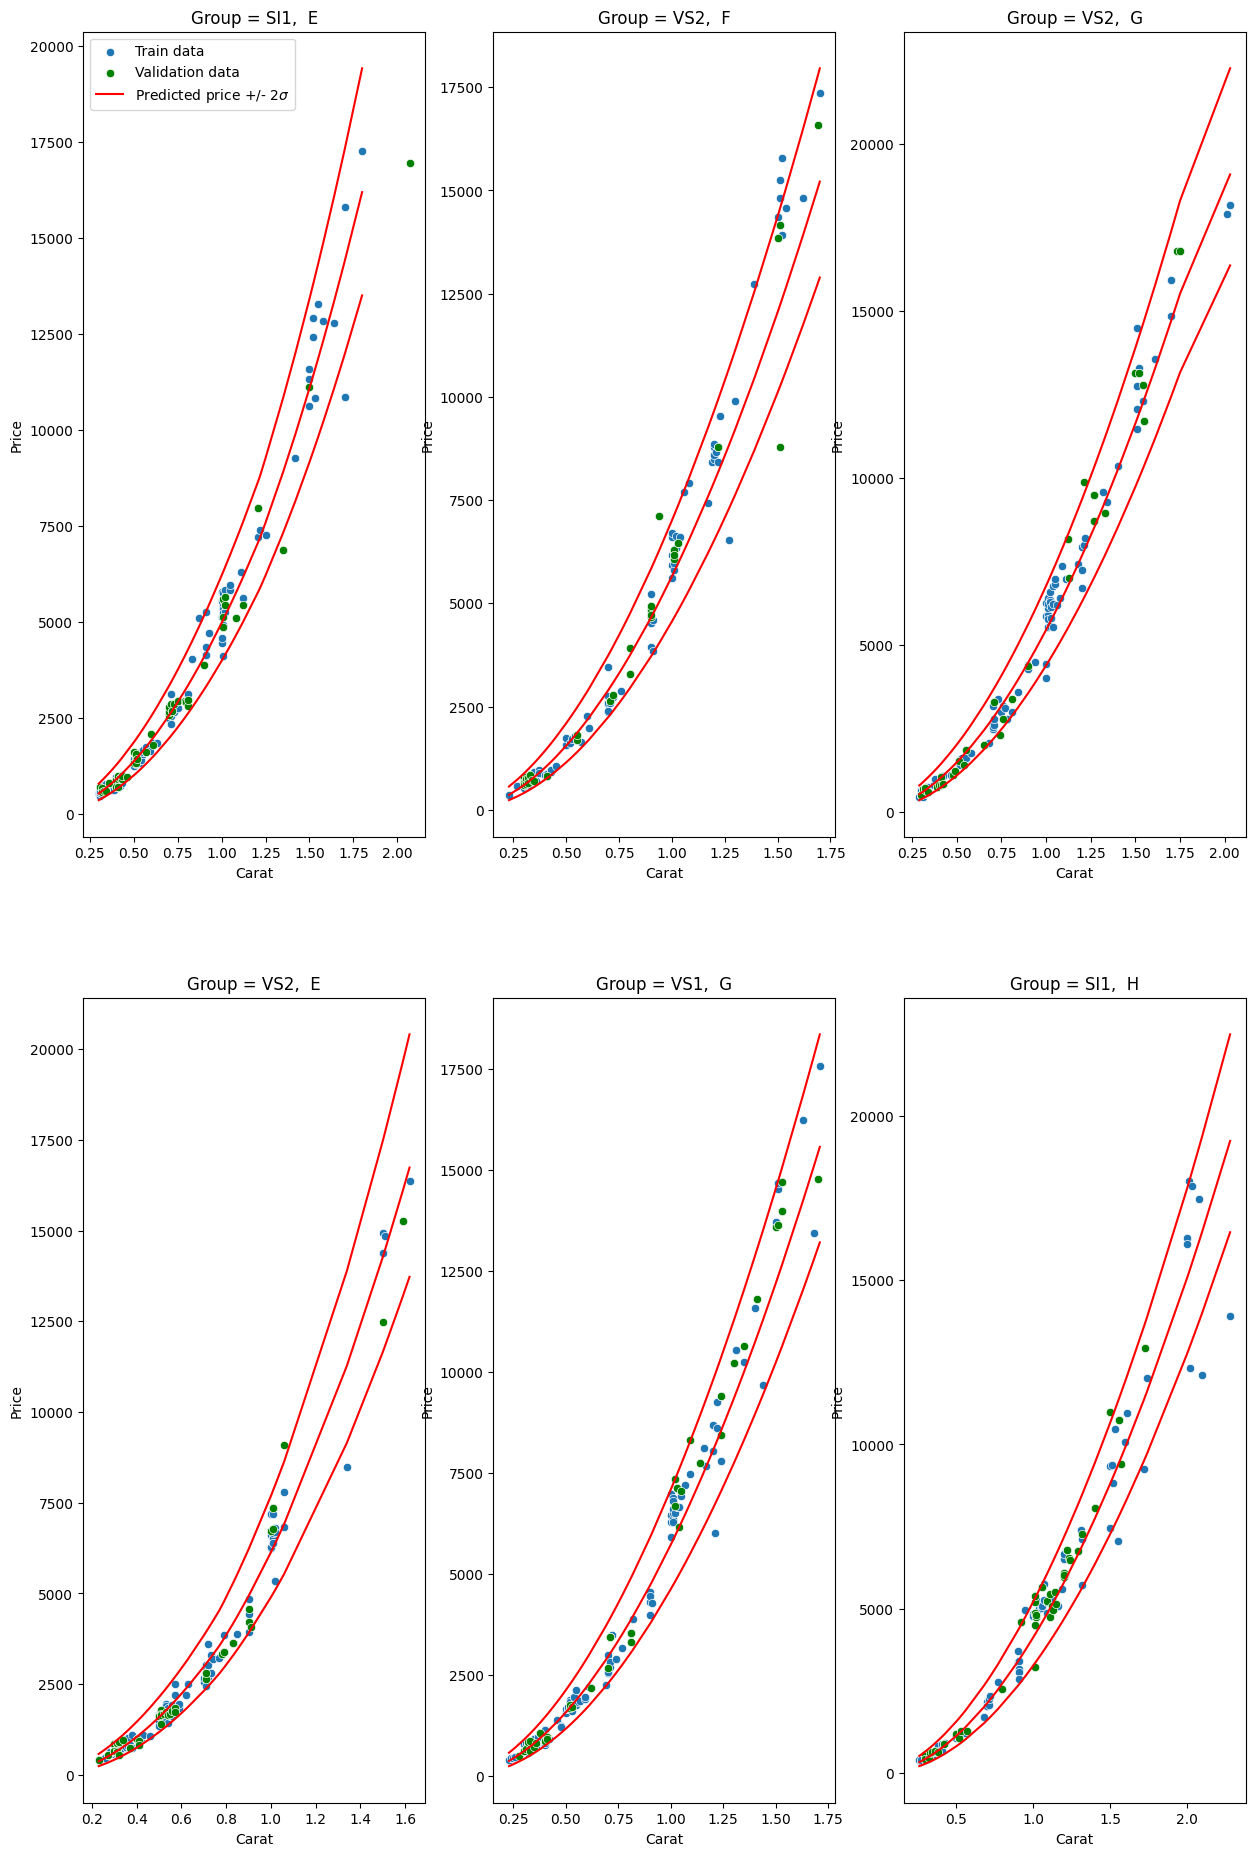

In [72]:
fig, axes = plt.subplots(2, 3, figsize = (15, 23))
group_numerosity = data.groupby(['color', 'clarity']).count()['carat'] 

for i, (idx, value) in  enumerate(group_numerosity[group_numerosity >195].items()): 
    selected_color, selected_clarity = idx
    print(i, i%2, i//2, selected_color, selected_clarity)

    color_idx, clarity_idx   = group_indices(selected_color, selected_clarity)
    x_train, y_train         = sorted_group_points(color_idx, clarity_idx, training_data)
    x_validation, y_validation           = sorted_group_points(color_idx, clarity_idx, validation_data)

    

    mean, log_std = model(x_train)
    mean, std = mean.squeeze().detach(), log_std.squeeze().detach().exp()

    plot_legend = True if i == 0 else False
    plot_group(
        mean, std,
        x_train, x_validation, y_train, y_validation, 
        selected_clarity, selected_color, axes[i%2, i//2], plot_legend)



### Results on the test set

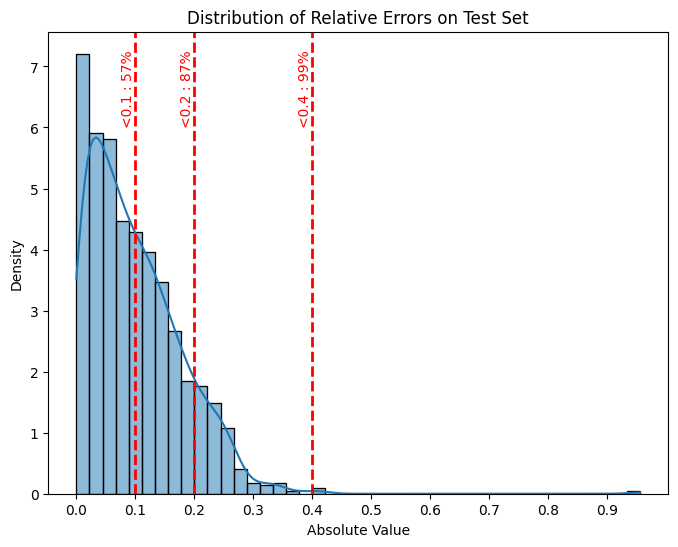

In [71]:
# Compute the prediction of the price (not log price) on the test set
predicted_price = m.predict(test_df).to_numpy()
predicted_price = np.exp(predicted_price)

# store the true price on the test set
true_price = test_df['price'].to_numpy()

# COmpute the absolute
abs_err = np.abs(predicted_price - true_price)/true_price

# Compute quantiles
error_thresholds =np.array([0.1, 0.2, 0.4])
pm = list()
for e in error_thresholds:
    pm.append((abs_err < e).mean())

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(abs_err, kde=True, stat='density')
plt.title('Distribution of Relative Errors on Test Set')
plt.xlabel('Absolute Value')
plt.ylabel('Density')
plt.xticks(np.arange(0, 1, 0.1))

# Plot quantiles as vertical lines
for q, p in zip(error_thresholds, pm):
    plt.axvline(q, color='r', linestyle='--', linewidth=2, label=f'Quantile at {q:.1f}')
    plt.text(q, 6., f'<{q} : {int(p*100)}%', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='r')

# plt.legend()
plt.show()

In [111]:
# import and convert the test data for evaluation of the nn model
test_data      = convert_to_torch_carat_color(test_df)

# evaluate mean and std of price
model.eval()
with torch.no_grad():
    mean, log_std = model(test_data.tensors[0])
mean, std = mean.squeeze().detach(), log_std.squeeze().detach().exp()

true_price = test_data.tensors[1].squeeze().detach()

# compute the percentage of predictions within 1 std
std_1 = (true_price - mean).abs() < std 
std_1 = std_1.float().mean()
print(f'Percentage of predictions within 1 std {std_1:.2f}')

std_2 = (true_price - mean).abs() < 2*std 
std_2 = std_2.float().mean()
print(f'Percentage of predictions within 2 std {std_2:.2f}')

std_3 = (true_price - mean).abs() < 3*std 
std_3 = std_3.float().mean()
print(f'Percentage of predictions within 3 std {std_3:.2f}')

Percentage of predictions within 1 std 0.71
Percentage of predictions within 2 std 0.96
Percentage of predictions within 3 std 0.99


In [114]:
# normality check using shapiro wilk test 
from scipy.stats import shapiro


# Perform Shapiro-Wilk test for normality
statistic, p_value = shapiro ( (true_price - mean).numpy() )

print(f"Shapiro-Wilk Test Results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value > alpha:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")


Shapiro-Wilk Test Results:
Statistic: 0.9967106928053339
P-value: 0.035553011895939346
Residuals are not normally distributed (reject H0)
